# Converting from GeoDataFrame to Graph and back

The model situation expects to have all input data for analysis in `GeoDataFrames`, including street network (e.g. from shapefile).

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
streets = gpd.read_file(momepy.datasets.get_path('bubenec'), layer='streets')

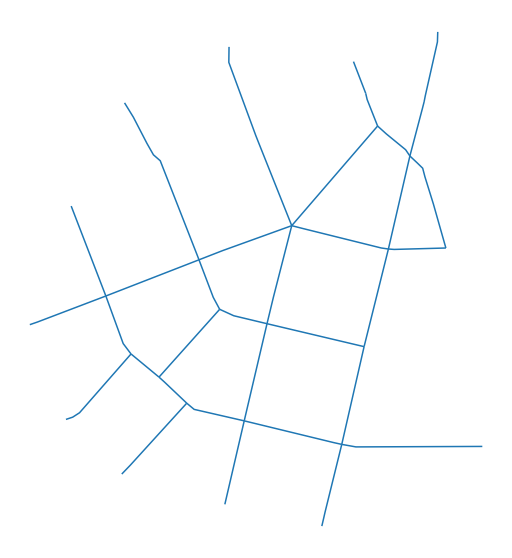

In [3]:
f, ax = plt.subplots(figsize=(10, 10))
streets.plot(ax=ax)
ax.set_axis_off()
plt.show()

We have to convert this LineString GeoDataFrame to a `networkx.Graph`. We use `momepy.gdf_to_nx` and later `momepy.nx_to_gdf` as a pair of interconnected functions. `gdf_to_nx` supports both primal and dual graphs. The primal approach will save the length of each segment to be used as a weight later, while dual will save the angle between segments (allowing angular centrality).

In [4]:
graph = momepy.gdf_to_nx(streets, approach='primal')

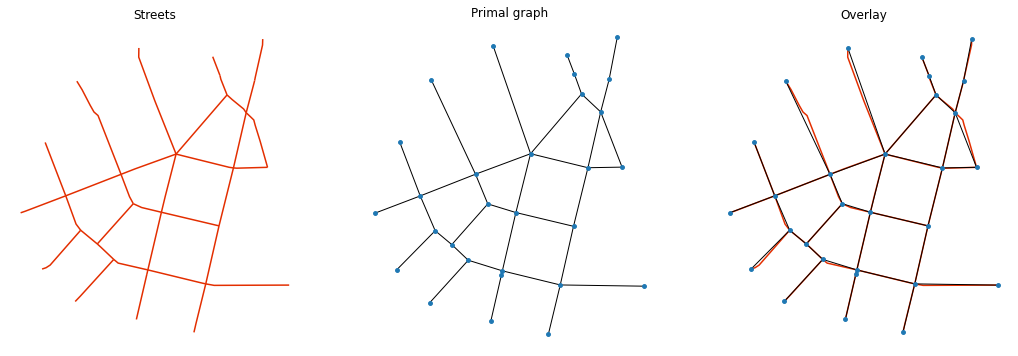

In [14]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
streets.plot(color='#e32e00', ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(graph, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[1], node_size=15)
streets.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(graph, {n:[n[0], n[1]] for n in list(graph.nodes)}, ax=ax[2], node_size=15)

In [6]:
dual = momepy.gdf_to_nx(streets, approach='dual')

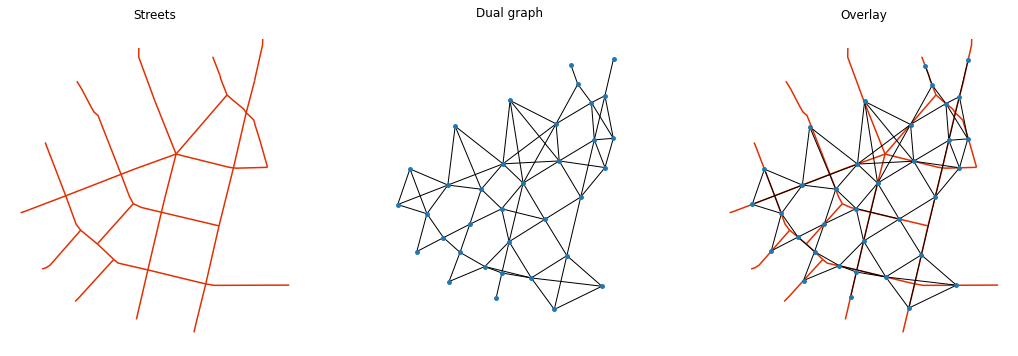

In [16]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
streets.plot(color='#e32e00', ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Dual graph", "Overlay")[i])
    facet.axis("off")
nx.draw(dual, {n:[n[0], n[1]] for n in list(dual.nodes)}, ax=ax[1], node_size=15)
streets.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(dual, {n:[n[0], n[1]] for n in list(dual.nodes)}, ax=ax[2], node_size=15)

At this moment (almost) any `networkx` method can be used. For illustration, we will measure the node degree. Using `networkx`, we can do:

In [7]:
degree = dict(nx.degree(graph))
nx.set_node_attributes(graph, degree, 'degree')

However, node degree is implemented in momepy so we can use directly:

In [8]:
graph = momepy.node_degree(graph, name='degree')

Once we have finished our network-based analysis, we want to convert the graph back to a geodataframe. For that, we will use `momepy.nx_to_gdf`, which gives us several options of what to export.

- `lines`
    - original LineString geodataframe
- `points`
    - point geometry representing street network intersections (nodes of primal graph)
- `spatial_weights`
    - spatial weights for nodes capturing their relationship within a network

Moreover, `edges` will contain `node_start` and `node_end` columns capturing the ID of both nodes at its ends.

In [9]:
nodes, edges, sw = momepy.nx_to_gdf(graph, points=True, lines=True,
                                    spatial_weights=True)

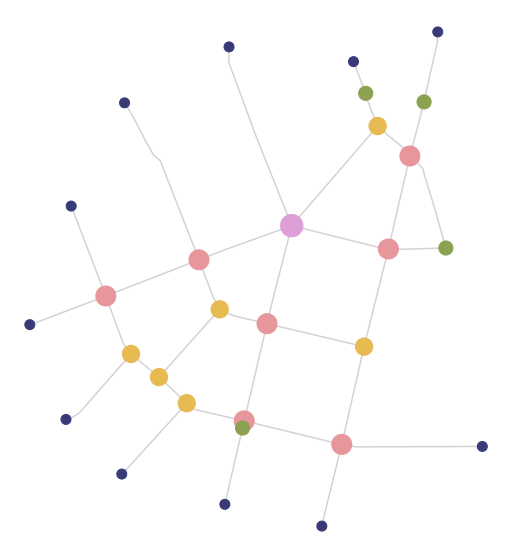

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, column='degree', cmap='tab20b', markersize=(nodes['degree'] * 100), zorder=2)
edges.plot(ax=ax, color='lightgrey', zorder=1)
ax.set_axis_off()
plt.show()


In [11]:
nodes.head(3)

,degree,nodeID,geometry
0,3,1,POINT (1603585.640 6464428.774)
1,5,2,POINT (1603413.206 6464228.730)
2,3,3,POINT (1603268.502 6464060.781)


In [12]:
edges.head(3)

,geometry,mm_len,node_start,node_end
0,"LINESTRING (1603585.640 6464428.774, 1603413.2...",264.103950,1,2
1,"LINESTRING (1603561.740 6464494.467, 1603564.6...",70.020202,1,9
2,"LINESTRING (1603585.640 6464428.774, 1603603.0...",88.924305,1,7
